In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

Изучим данные. 

In [3]:
df = pd.read_csv("~/GitHubRepos/FinancialEconometrics/DataWork/Data/General_ds_cleaned.csv")
# df = df[["date", "beta0", "beta1", "beta2", "tau", "WLbeta0", "WLbeta1", "WLbeta2", "WLtau"]]
df = df[["date", "Y025", "0.5", "0.75", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "15.0", "20.0", "30.0"]]
df["date"] = pd.to_datetime(df["date"], yearfirst=True)
df.set_index("date", drop=True, inplace=True)
df

,Y025,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0
date,,,,,,,,,,,,
2003-01-04,11.68,12.31,12.76,13.08,13.63,13.72,13.63,13.53,13.45,13.38,13.35,13.32
2003-01-05,11.09,11.70,12.16,12.50,13.14,13.30,13.31,13.27,13.23,13.20,13.19,13.17
2003-01-08,10.84,11.61,12.15,12.53,13.18,13.30,13.29,13.24,13.19,13.15,13.13,13.11
2003-01-09,10.46,11.13,11.67,12.09,13.02,13.31,13.38,13.32,13.25,13.19,13.16,13.13
2003-01-10,10.10,11.08,11.79,12.28,13.14,13.31,13.27,13.19,13.11,13.04,13.00,12.97
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,13.29,12.15,11.71,11.55,11.52,11.54,11.61,11.68,11.74,11.78,11.78,11.77
2023-11-28,13.15,12.13,11.74,11.60,11.57,11.54,11.57,11.65,11.73,11.77,11.77,11.77
2023-11-29,13.30,12.05,11.58,11.43,11.49,11.53,11.59,11.65,11.71,11.74,11.75,11.75


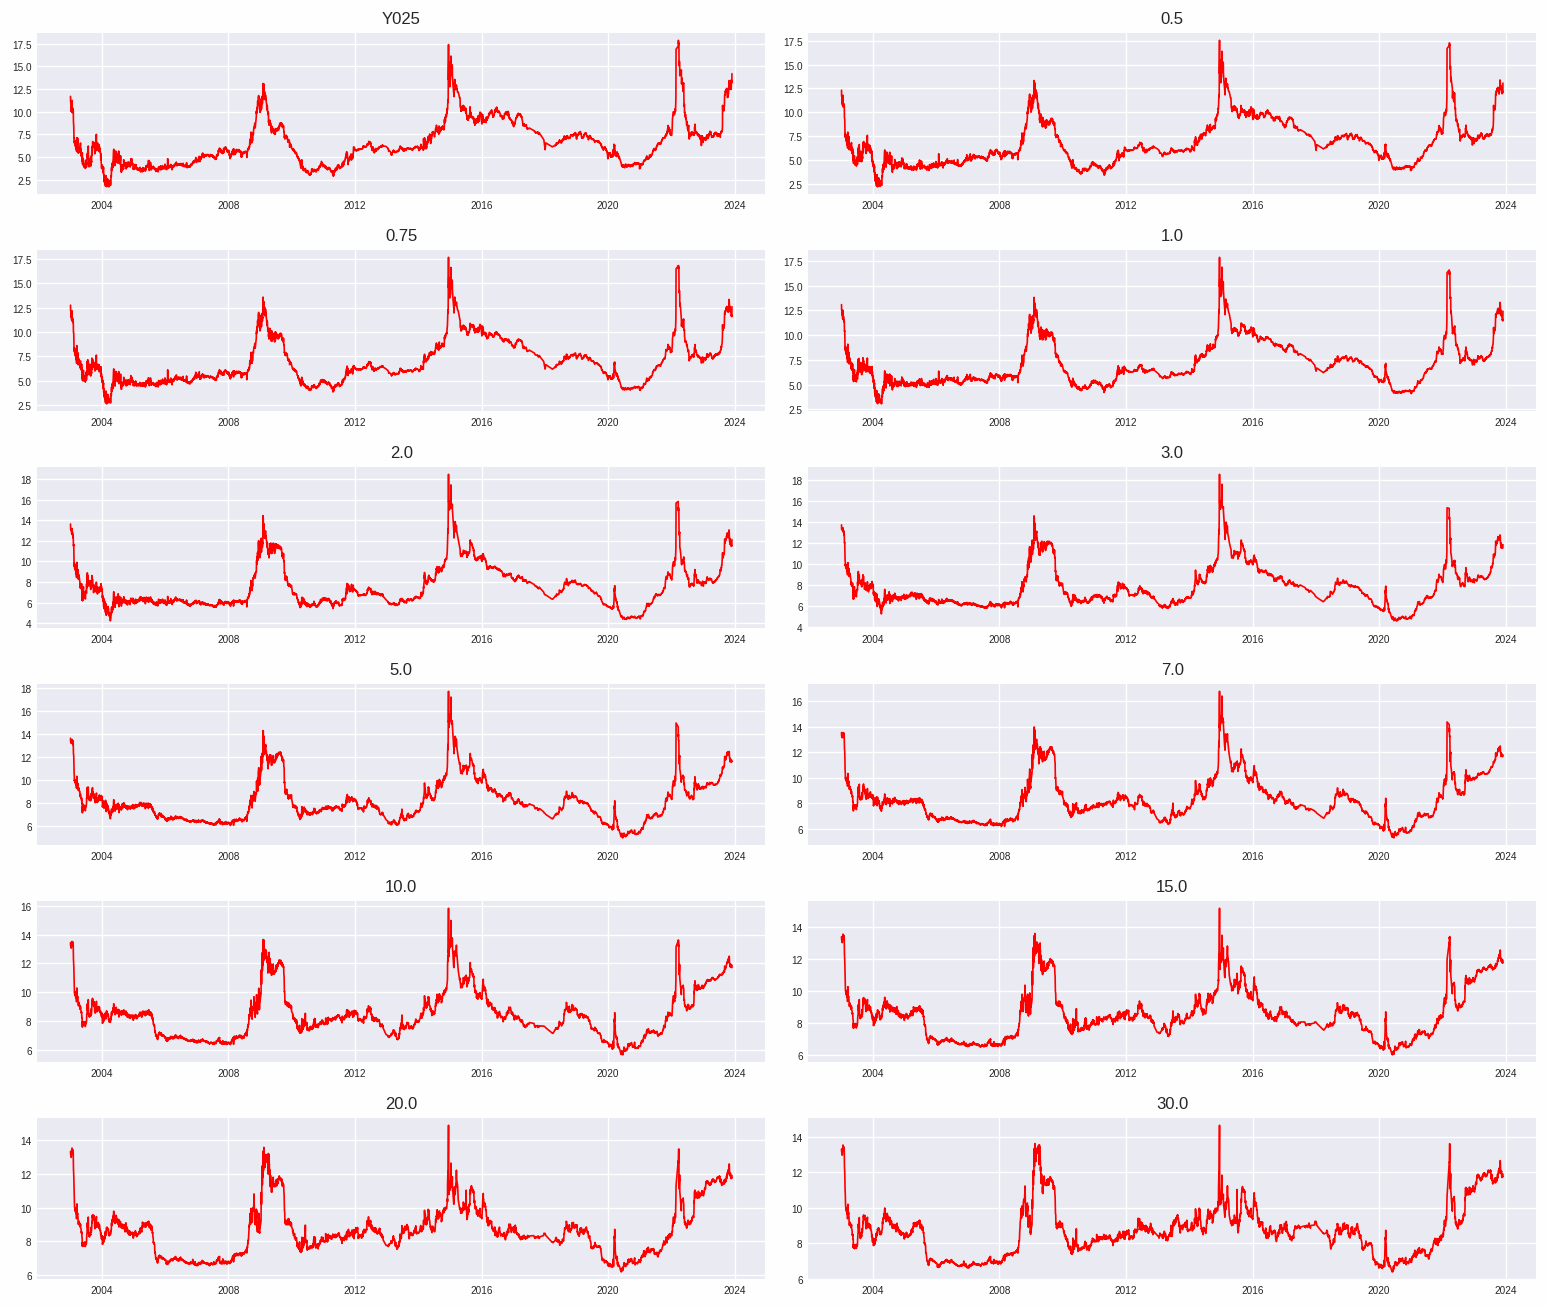

In [4]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(13,11))
for i, ax in enumerate(axes.flat):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Теперь приступим к разбивке на test и train(с помощью дат полученных из структурных сдвигов). Для train вычитают 5 дней от структурного сдвига, а промежуток в 5 дней беру на test.
### МЕНЯТЬ ТОЛЬКО ЗДЕСЬ!!!
1. n_horizon — количество дней, на которое предсказываем 
1. epoch — промежуток, который исследуем

Проверим на стационарность.

In [5]:
def adjust(val, length= 6): return str(val).ljust(length)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [6]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y025" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8999
 No. Lags Chosen       = 32
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0454. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9831
 No. Lags Chosen       = 32
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0365. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.75" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

Получили, что все не стационарно. Возьмем разницу и снова проверим.

In [7]:
df_differenced = df.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y025" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6308
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8321
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.75" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

Зафитим нашу модель для двух режимов(high/low vol). Также отбираем лучшую модель по AIC.

Добавим столбец regime для наглядности какой режим в текущую дату.

In [12]:
df_differenced

,Y025,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0
date,,,,,,,,,,,,
2003-01-05,-0.59,-0.61,-0.60,-0.58,-0.49,-0.42,-0.32,-0.26,-0.22,-0.18,-0.16,-0.15
2003-01-08,-0.25,-0.09,-0.01,0.03,0.04,0.00,-0.02,-0.03,-0.04,-0.05,-0.06,-0.06
2003-01-09,-0.38,-0.48,-0.48,-0.44,-0.16,0.01,0.09,0.08,0.06,0.04,0.03,0.02
2003-01-10,-0.36,-0.05,0.12,0.19,0.12,0.00,-0.11,-0.13,-0.14,-0.15,-0.16,-0.16
2003-01-13,0.23,0.26,0.23,0.18,-0.01,-0.09,-0.09,-0.07,-0.05,-0.03,-0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,-0.21,-0.11,-0.03,0.01,0.01,-0.03,-0.03,-0.01,0.02,0.04,0.03,0.03
2023-11-28,-0.14,-0.02,0.03,0.05,0.05,0.00,-0.04,-0.03,-0.01,-0.01,-0.01,0.00
2023-11-29,0.15,-0.08,-0.16,-0.17,-0.08,-0.01,0.02,0.00,-0.02,-0.03,-0.02,-0.02


In [8]:
df_with_regimes = df.copy()

for i in df.columns:
    model_markov = sm.tsa.MarkovRegression(df_differenced[i], k_regimes=2, trend="n", switching_variance=True)
    markov_model_fit = model_markov.fit()
    new_df = markov_model_fit.smoothed_marginal_probabilities
    df_with_regimes[i + '_regimes'] = (new_df[0] < new_df[1])

df_with_regimes = df_with_regimes[1:]

for i in df.columns:
    df_with_regimes[i + '_regimes'] = df_with_regimes[i + '_regimes'].astype(int)

df_with_regimes


,Y025,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,...,0.75_regimes,1.0_regimes,2.0_regimes,3.0_regimes,5.0_regimes,7.0_regimes,10.0_regimes,15.0_regimes,20.0_regimes,30.0_regimes
date,,,,,,,,,,,,,,,,,,,,,
2003-01-05,11.09,11.70,12.16,12.50,13.14,13.30,13.31,13.27,13.23,13.20,...,1,1,1,1,1,1,1,1,0,0
2003-01-08,10.84,11.61,12.15,12.53,13.18,13.30,13.29,13.24,13.19,13.15,...,1,1,1,0,0,0,0,0,0,0
2003-01-09,10.46,11.13,11.67,12.09,13.02,13.31,13.38,13.32,13.25,13.19,...,1,1,1,0,0,0,0,0,0,0
2003-01-10,10.10,11.08,11.79,12.28,13.14,13.31,13.27,13.19,13.11,13.04,...,1,1,1,0,0,0,0,0,0,0
2003-01-13,10.33,11.34,12.02,12.46,13.13,13.22,13.18,13.12,13.06,13.01,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,13.29,12.15,11.71,11.55,11.52,11.54,11.61,11.68,11.74,11.78,...,0,0,0,0,0,0,0,0,0,0
2023-11-28,13.15,12.13,11.74,11.60,11.57,11.54,11.57,11.65,11.73,11.77,...,0,0,0,0,0,0,0,0,0,0
2023-11-29,13.30,12.05,11.58,11.43,11.49,11.53,11.59,11.65,11.71,11.74,...,0,1,0,0,0,0,0,0,0,0


<Axes: xlabel='date'>

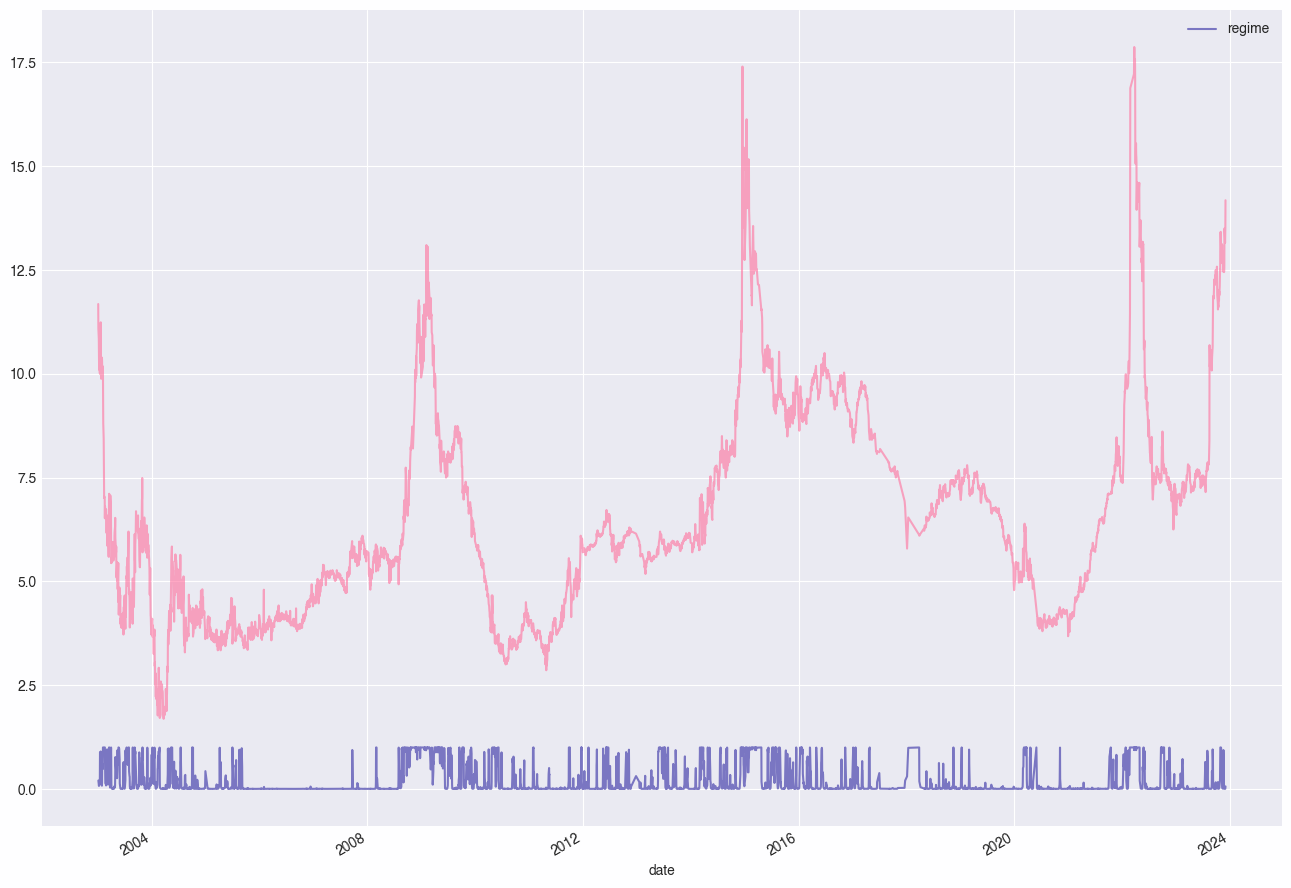

In [11]:
name = "0.25"
model_markov = sm.tsa.MarkovAutoregression(df_differenced[name], order=1, k_regimes=2, trend="n", switching_variance=True).fit()
plot_probability = markov_model_fit.smoothed_marginal_probabilities[1].to_frame('regime')
plot_probability.plot(figsize = (16,12))
df[name].plot()


Нарисуем картинки, отражающие в каком режиме находится кривая в конкретный момент.

ValueError: zero-size array to reduction operation maximum which has no identity

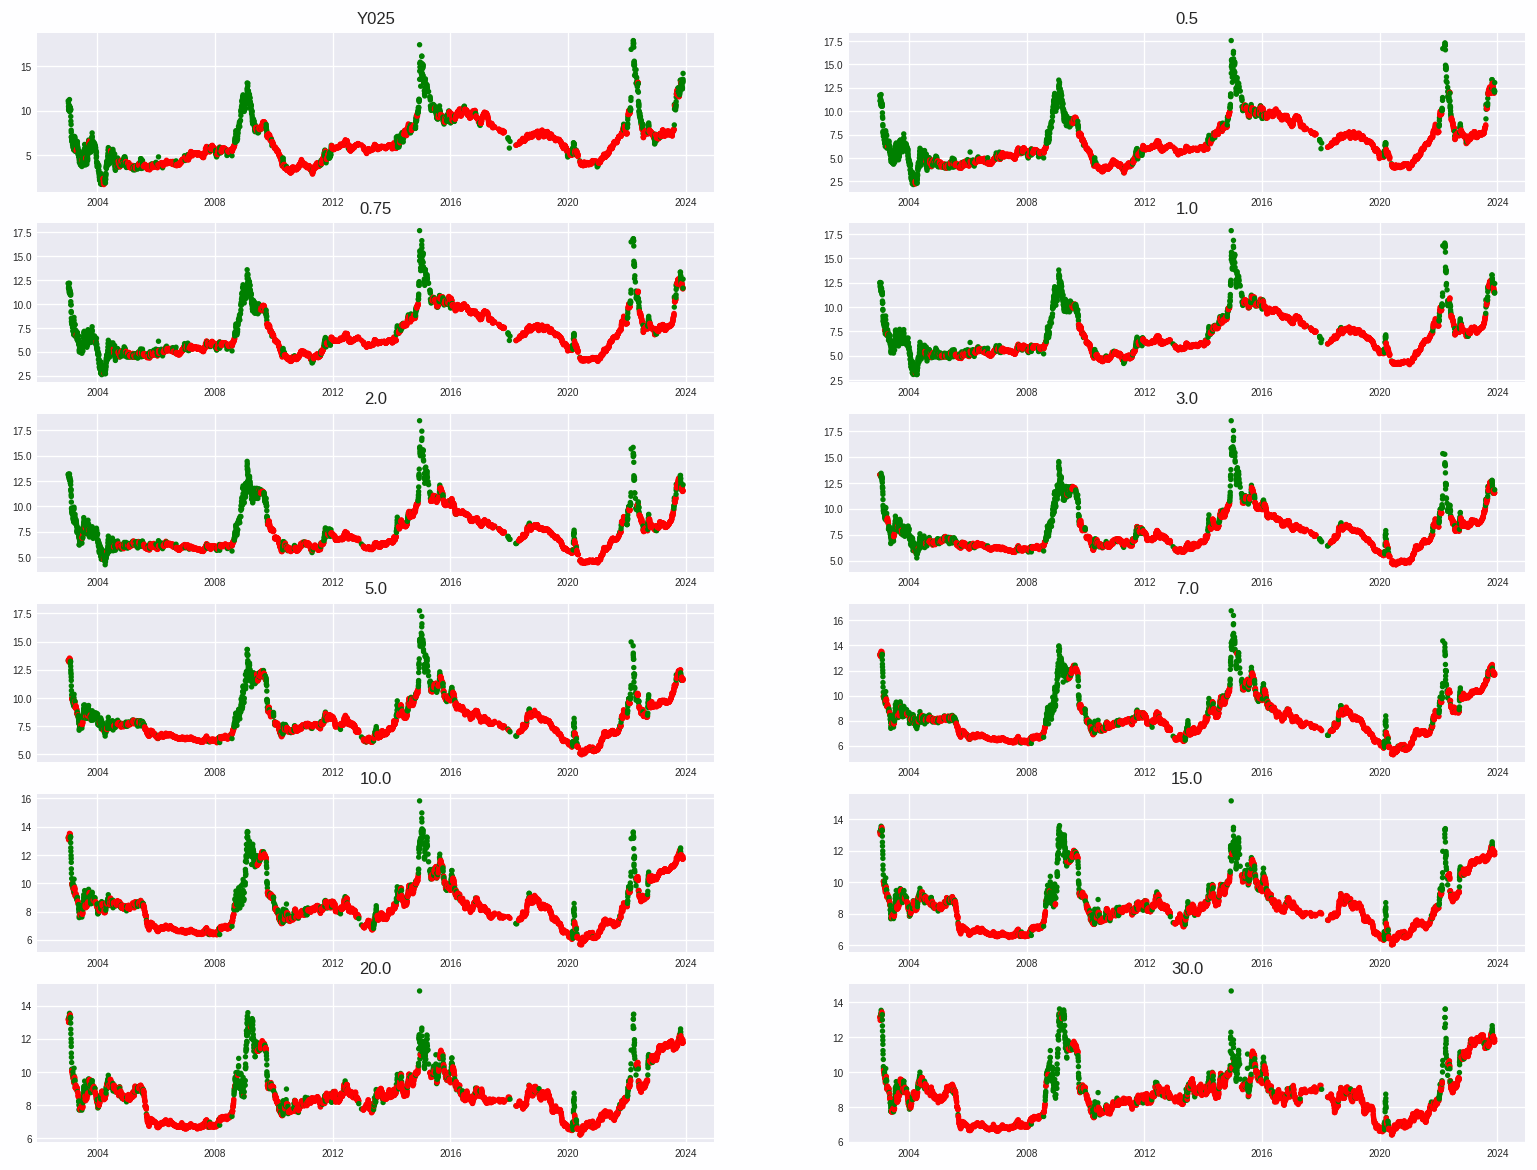

In [13]:

colors = np.array(["red", "green"])
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(16,12))

for i, ax in enumerate(axes.flat):
    ax.scatter(df_with_regimes.index, df_with_regimes[df_with_regimes.columns[i]], c = colors[df_with_regimes[df_with_regimes.columns[i]+"_regimes"]], marker="o", linestyle="", s = 5)
    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

# plt.savefig("Markov switching regime.pdf")
plt.tight_layout()

In [14]:
def create_time_feature(df):
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.day_of_year
    df['weekofyear'] = df.index.weekofyear
    return df

In [15]:
n_horizon = 5
dates_from_struct_ms = np.array([0, 657, 1384, 3943, 4502])


time_to_fit = np.maximum((dates_from_struct_ms - n_horizon), np.zeros(len(dates_from_struct_ms))).astype(int)
time_to_predict = dates_from_struct_ms

epoch = 3
dataset_train, dataset_test = df_with_regimes[time_to_fit[epoch]:time_to_fit[epoch + 1]].copy(), df_with_regimes[time_to_fit[epoch + 1]:time_to_predict[epoch + 1]].copy()
dataset_train = create_time_feature(dataset_train)
dataset_test = create_time_feature(dataset_test)

Выберем претендента на форкаст в ARIMAX.

In [33]:
def find_best_parametrs(df_to_analyze, general_df):
    max_parametrs_for_q = 4
    df_fc = df_to_analyze[['dayofmonth', 'dayofweek', 'quarter', 'month', 'dayofyear', 'weekofyear']].copy()
    mas_best_param = []

    for colname in general_df.columns:
        aic_dict = {}
        temp = pd.concat([df_fc, df_to_analyze[colname + "_regimes"]] , axis=1)
        for i in np.arange(1,max_parametrs_for_q):
            for j in np.arange(1,max_parametrs_for_q):
                for l in np.arange(1,max_parametrs_for_q):
                    arima_model = ARIMA(df_to_analyze[colname], exog=temp, order=(i,j,l))
                    result = arima_model.fit()
                    aic_dict[f"({i}, {j}, {l})"] = result.aic
        aic_dict = pd.DataFrame(aic_dict.values(), index=aic_dict.keys(), columns=[colname])
        mas_best_param.append(aic_dict[aic_dict == aic_dict[colname].min()].dropna())

    return mas_best_param

In [34]:
find_best_parametrs(dataset_train, df)

[                 0.25
 (1, 1, 1) -841.942618,
                   0.5
 (2, 1, 1) -992.284174,
                   0.75
 (2, 1, 1) -1078.459191,
                    1.0
 (2, 1, 1) -1124.858224,
                    2.0
 (2, 1, 1) -1163.487991,
                    3.0
 (2, 1, 1) -1123.553471,
                    5.0
 (3, 1, 3) -1077.681724,
                    7.0
 (3, 1, 3) -1083.707203,
                   10.0
 (1, 1, 2) -1126.878241,
                  15.0
 (3, 1, 2) -1175.54915,
                   20.0
 (3, 1, 2) -1192.212015,
                   30.0
 (1, 1, 2) -1176.200687]

In [23]:
df_fc = dataset_train[['dayofmonth', 'dayofweek', 'quarter', 'month', 'dayofyear', 'weekofyear']].copy()
arima_model_025 = ARIMA(dataset_train["Y025"], exog=pd.concat([df_fc, dataset_train["Y025_regimes"]] , axis=1), order=(1,1,1)).fit()
arima_model_05 = ARIMA(dataset_train["0.5"], exog=pd.concat([df_fc, dataset_train["0.5_regimes"]] , axis=1), order=(2,1,1)).fit()
arima_model_075 = ARIMA(dataset_train["0.75"], exog=pd.concat([df_fc, dataset_train["0.75_regimes"]] , axis=1), order=(2,1,1)).fit()
arima_model_1 = ARIMA(dataset_train["1.0"], exog=pd.concat([df_fc, dataset_train["1.0_regimes"]] , axis=1), order=(2,1,1)).fit()
arima_model_2 = ARIMA(dataset_train["2.0"], exog=pd.concat([df_fc, dataset_train["2.0_regimes"]] , axis=1), order=(2,1,1)).fit()
arima_model_3 = ARIMA(dataset_train["3.0"], exog=pd.concat([df_fc, dataset_train["3.0_regimes"]] , axis=1), order=(2,1,1)).fit()
arima_model_5 = ARIMA(dataset_train["5.0"], exog=pd.concat([df_fc, dataset_train["5.0_regimes"]] , axis=1), order=(3,1,3)).fit()
arima_model_7 = ARIMA(dataset_train["7.0"], exog=pd.concat([df_fc, dataset_train["7.0_regimes"]] , axis=1), order=(3,1,3)).fit()
arima_model_10 = ARIMA(dataset_train["10.0"], exog=pd.concat([df_fc, dataset_train["10.0_regimes"]] , axis=1), order=(1,1,2)).fit()
arima_model_15 = ARIMA(dataset_train["15.0"], exog=pd.concat([df_fc, dataset_train["15.0_regimes"]] , axis=1), order=(3,1,2)).fit()
arima_model_20 = ARIMA(dataset_train["20.0"], exog=pd.concat([df_fc, dataset_train["20.0_regimes"]] , axis=1), order=(3,1,2)).fit()
arima_model_30 = ARIMA(dataset_train["30.0"], exog=pd.concat([df_fc, dataset_train["30.0_regimes"]] , axis=1), order=(1,1,2)).fit()

In [24]:
USUALarima_model_025 = ARIMA(dataset_train["Y025"], order=(1,1,1)).fit()
USUALarima_model_05 = ARIMA(dataset_train["0.5"], order=(2,1,1)).fit()
USUALarima_model_075 = ARIMA(dataset_train["0.75"], order=(2,1,1)).fit()
USUALarima_model_1 = ARIMA(dataset_train["1.0"], order=(2,1,1)).fit()
USUALarima_model_2 = ARIMA(dataset_train["2.0"], order=(2,1,1)).fit()
USUALarima_model_3 = ARIMA(dataset_train["3.0"], order=(2,1,1)).fit()
USUALarima_model_5 = ARIMA(dataset_train["5.0"], order=(3,1,3)).fit()
USUALarima_model_7 = ARIMA(dataset_train["7.0"], order=(3,1,3)).fit()
USUALarima_model_10 = ARIMA(dataset_train["10.0"], order=(1,1,2)).fit()
USUALarima_model_15 = ARIMA(dataset_train["15.0"], order=(3,1,2)).fit()
USUALarima_model_20 = ARIMA(dataset_train["20.0"], order=(3,1,2)).fit()
USUALarima_model_30 = ARIMA(dataset_train["30.0"], order=(1,1,2)).fit()

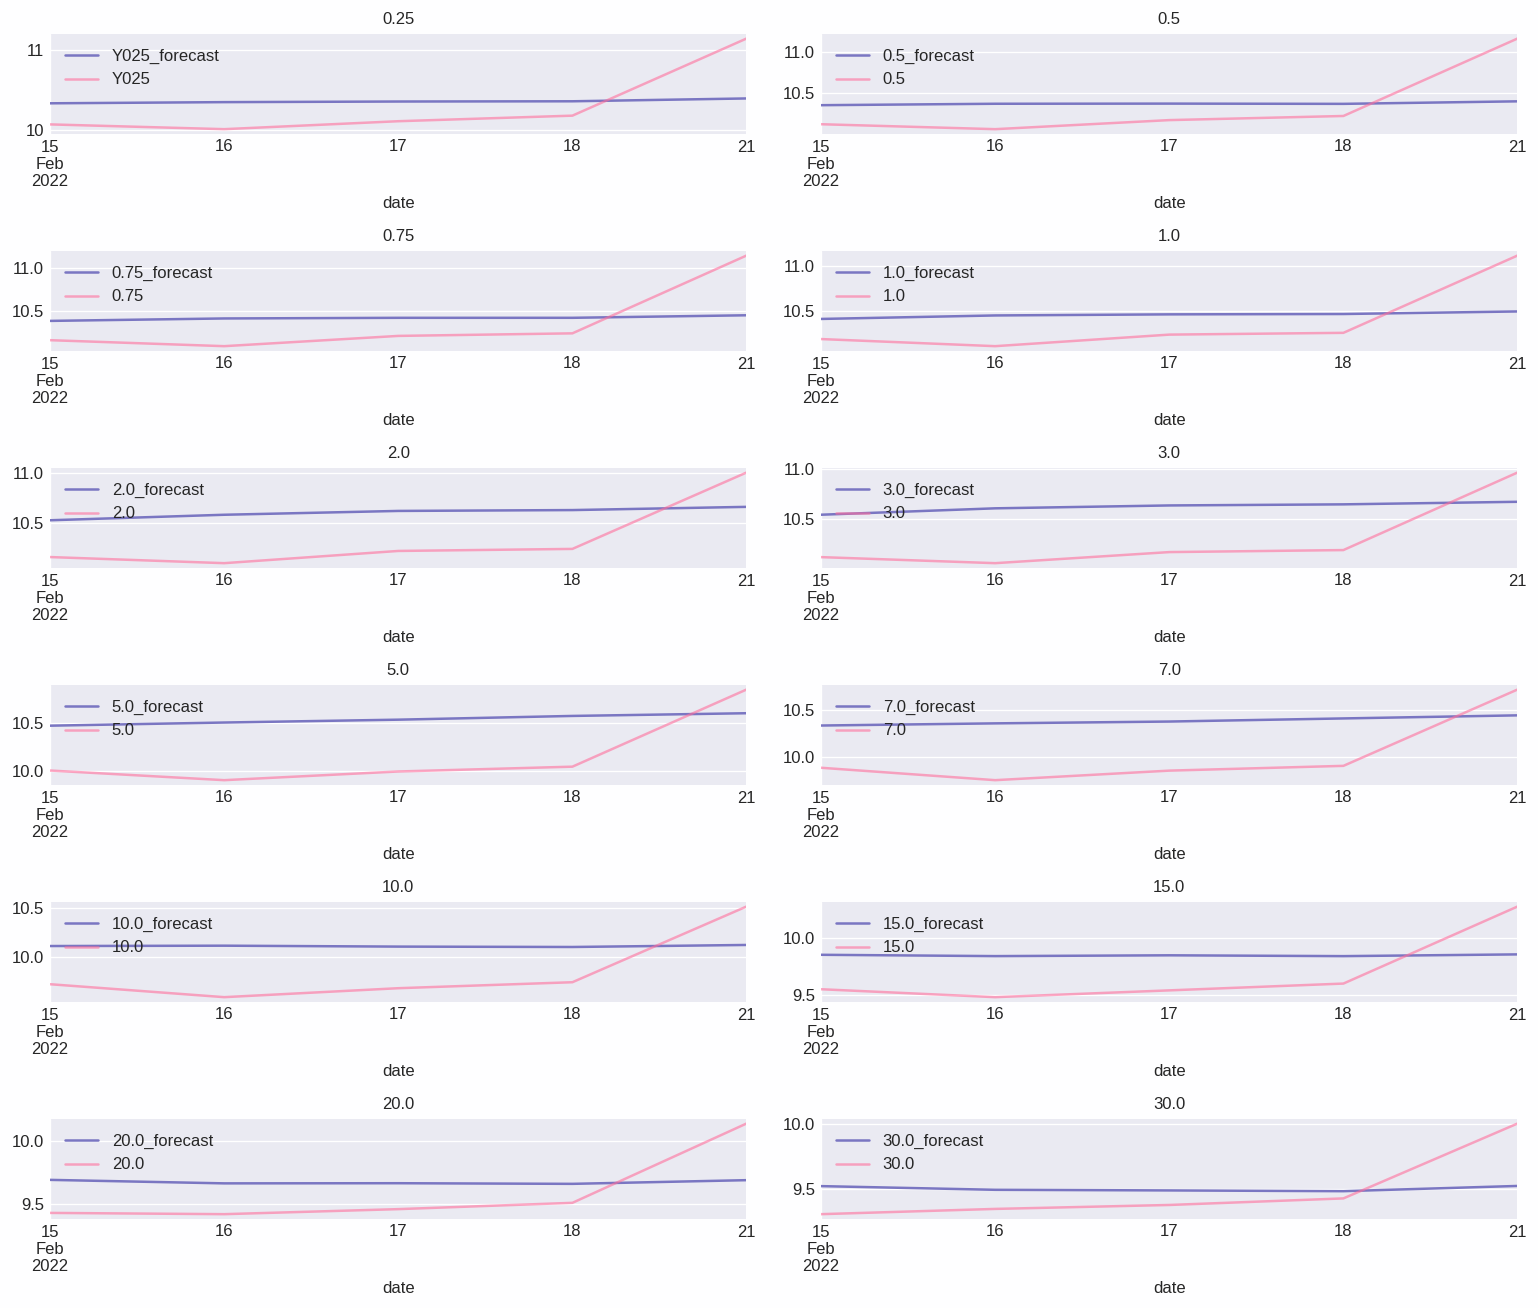

In [31]:
df_fc = dataset_test[['dayofmonth', 'dayofweek', 'quarter', 'month', 'dayofyear', 'weekofyear']].copy()
df_test_allresult = dataset_test.copy()

fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(13,11))

df_test_allresult["Y025_forecast"] = np.array(arima_model_025.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["Y025_regimes"]] , axis=1)))
df_test_allresult["Y025_forecast"].plot(ax=axes.flat[0], legend="test")
df_test_allresult["Y025"].plot(ax=axes.flat[0], legend="forecast")
axes.flat[0].set_title("0.25", fontsize=10)

df_test_allresult["0.5_forecast"] = np.array(arima_model_05.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["0.5_regimes"]] , axis=1)))
df_test_allresult["0.5_forecast"].plot(ax=axes.flat[1], legend="test")
df_test_allresult["0.5"].plot(ax=axes.flat[1], legend="forecast")
axes.flat[1].set_title("0.5", fontsize=10)

df_test_allresult["0.75_forecast"] = np.array(arima_model_075.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["0.75_regimes"]] , axis=1)))
df_test_allresult["0.75_forecast"].plot(ax=axes.flat[2], legend="test")
df_test_allresult["0.75"].plot(ax=axes.flat[2], legend="forecast")
axes.flat[2].set_title("0.75", fontsize=10)

df_test_allresult["1.0_forecast"] = np.array(arima_model_1.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["1.0_regimes"]] , axis=1)))
df_test_allresult["1.0_forecast"].plot(ax=axes.flat[3], legend="test")
df_test_allresult["1.0"].plot(ax=axes.flat[3], legend="forecast")
axes.flat[3].set_title("1.0", fontsize=10)


df_test_allresult["2.0_forecast"] = np.array(arima_model_2.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["2.0_regimes"]] , axis=1)))
df_test_allresult["2.0_forecast"].plot(ax=axes.flat[4], legend="test")
df_test_allresult["2.0"].plot(ax=axes.flat[4], legend="forecast")
axes.flat[4].set_title("2.0", fontsize=10)

df_test_allresult["3.0_forecast"] = np.array(arima_model_3.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["3.0_regimes"]] , axis=1)))
df_test_allresult["3.0_forecast"].plot(ax=axes.flat[5], legend="test")
df_test_allresult["3.0"].plot(ax=axes.flat[5], legend="forecast")
axes.flat[5].set_title("3.0", fontsize=10)

df_test_allresult["5.0_forecast"] = np.array(arima_model_5.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["5.0_regimes"]] , axis=1)))
df_test_allresult["5.0_forecast"].plot(ax=axes.flat[6], legend="test")
df_test_allresult["5.0"].plot(ax=axes.flat[6], legend="forecast")
axes.flat[6].set_title("5.0", fontsize=10)

df_test_allresult["7.0_forecast"] = np.array(arima_model_7.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["7.0_regimes"]] , axis=1)))
df_test_allresult["7.0_forecast"].plot(ax=axes.flat[7], legend="test")
df_test_allresult["7.0"].plot(ax=axes.flat[7], legend="forecast")
axes.flat[7].set_title("7.0", fontsize=10)

df_test_allresult["10.0_forecast"] = np.array(arima_model_10.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["10.0_regimes"]] , axis=1)))
df_test_allresult["10.0_forecast"].plot(ax=axes.flat[8], legend="test")
df_test_allresult["10.0"].plot(ax=axes.flat[8], legend="forecast")
axes.flat[8].set_title("10.0", fontsize=10)

df_test_allresult["15.0_forecast"] = np.array(arima_model_15.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["15.0_regimes"]] , axis=1)))
df_test_allresult["15.0_forecast"].plot(ax=axes.flat[9], legend="test")
df_test_allresult["15.0"].plot(ax=axes.flat[9], legend="forecast")
axes.flat[9].set_title("15.0", fontsize=10)


df_test_allresult["20.0_forecast"] = np.array(arima_model_20.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["20.0_regimes"]] , axis=1)))
df_test_allresult["20.0_forecast"].plot(ax=axes.flat[10], legend="test")
df_test_allresult["20.0"].plot(ax=axes.flat[10], legend="forecast")
axes.flat[10].set_title("20.0", fontsize=10)

df_test_allresult["30.0_forecast"] = np.array(arima_model_30.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["30.0_regimes"]] , axis=1)))
df_test_allresult["30.0_forecast"].plot(ax=axes.flat[11], legend="test")
df_test_allresult["30.0"].plot(ax=axes.flat[11], legend="forecast")
axes.flat[11].set_title("30.0", fontsize=10)


plt.tight_layout();
plt.savefig("ARIMAX_MSFRCST.pdf")


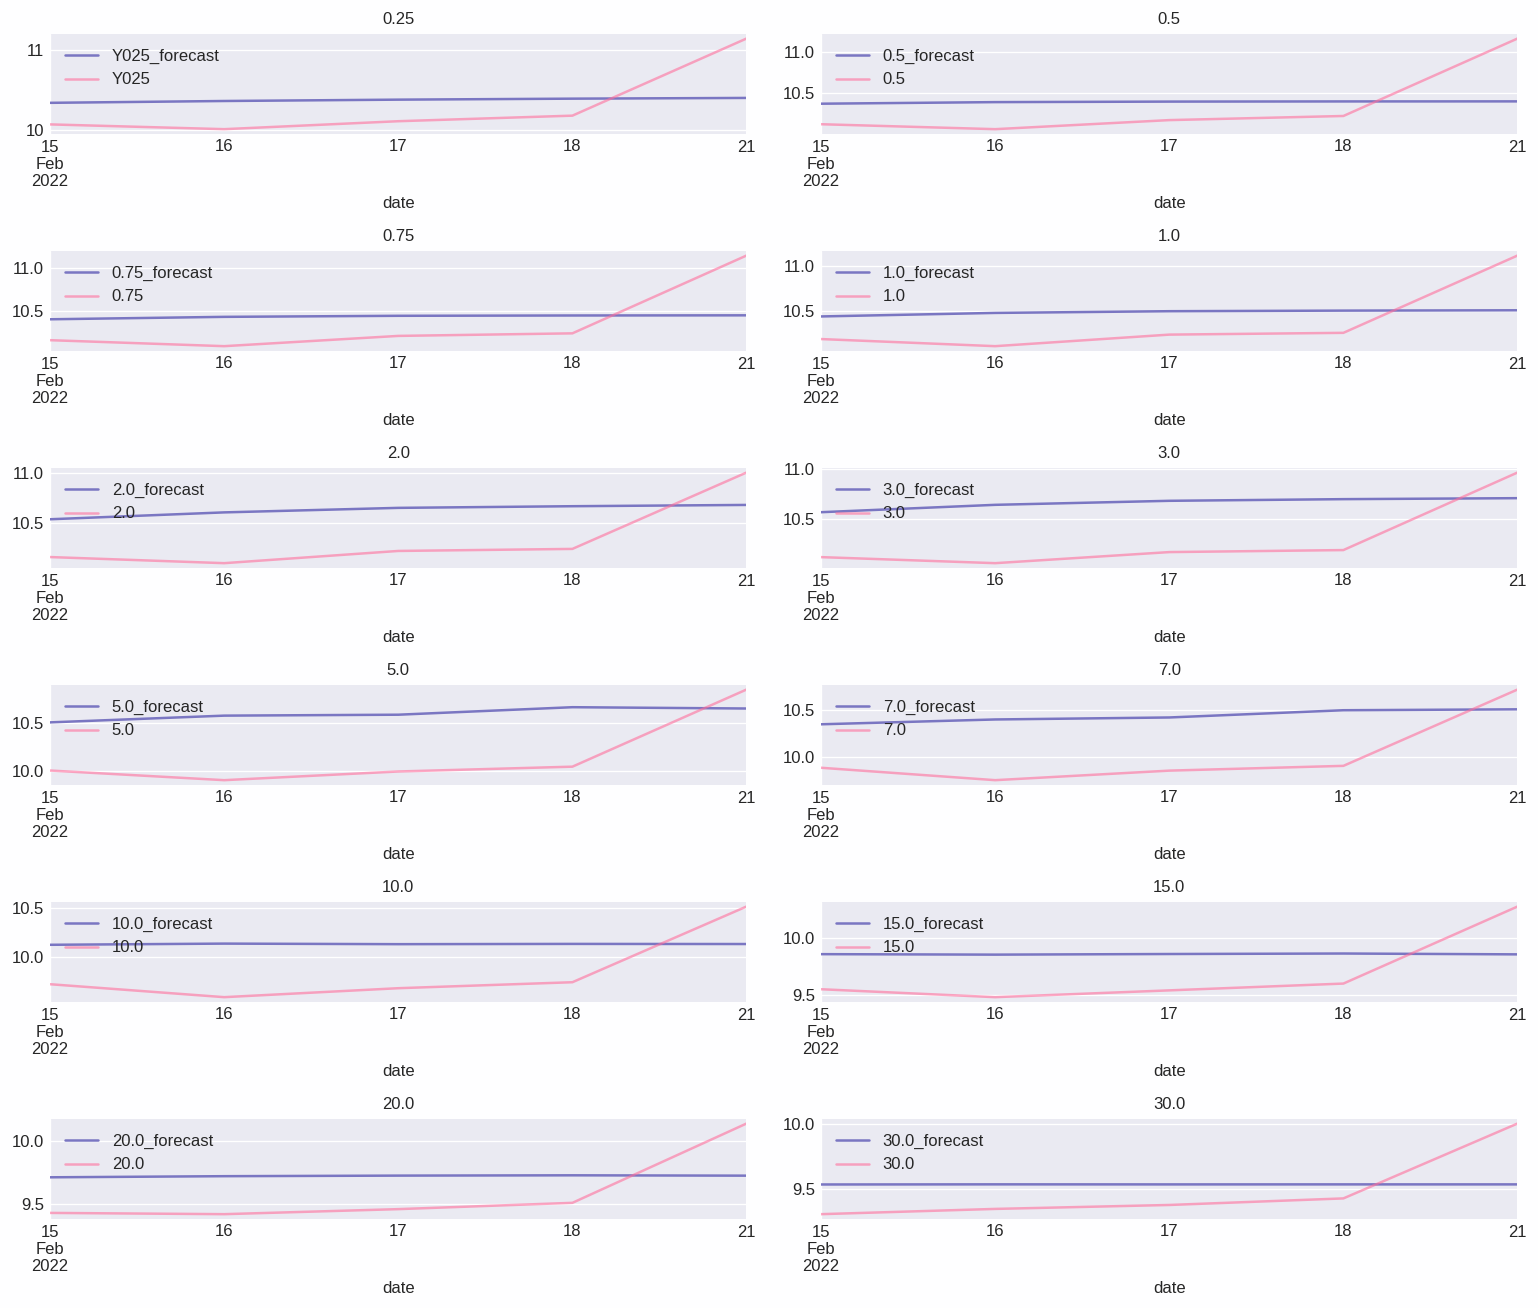

In [34]:
df_fc = dataset_test[['dayofmonth', 'dayofweek', 'quarter', 'month', 'dayofyear', 'weekofyear']].copy()
df_test_allresult = dataset_test.copy()

fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(13,11))

df_test_allresult["Y025_forecast"] = np.array(USUALarima_model_025.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["Y025_regimes"]] , axis=1)))
df_test_allresult["Y025_forecast"].plot(ax=axes.flat[0], legend="test")
df_test_allresult["Y025"].plot(ax=axes.flat[0], legend="forecast")
axes.flat[0].set_title("0.25", fontsize=10)

df_test_allresult["0.5_forecast"] = np.array(USUALarima_model_05.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["0.5_regimes"]] , axis=1)))
df_test_allresult["0.5_forecast"].plot(ax=axes.flat[1], legend="test")
df_test_allresult["0.5"].plot(ax=axes.flat[1], legend="forecast")
axes.flat[1].set_title("0.5", fontsize=10)

df_test_allresult["0.75_forecast"] = np.array(USUALarima_model_075.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["0.75_regimes"]] , axis=1)))
df_test_allresult["0.75_forecast"].plot(ax=axes.flat[2], legend="test")
df_test_allresult["0.75"].plot(ax=axes.flat[2], legend="forecast")
axes.flat[2].set_title("0.75", fontsize=10)

df_test_allresult["1.0_forecast"] = np.array(USUALarima_model_1.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["1.0_regimes"]] , axis=1)))
df_test_allresult["1.0_forecast"].plot(ax=axes.flat[3], legend="test")
df_test_allresult["1.0"].plot(ax=axes.flat[3], legend="forecast")
axes.flat[3].set_title("1.0", fontsize=10)


df_test_allresult["2.0_forecast"] = np.array(USUALarima_model_2.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["2.0_regimes"]] , axis=1)))
df_test_allresult["2.0_forecast"].plot(ax=axes.flat[4], legend="test")
df_test_allresult["2.0"].plot(ax=axes.flat[4], legend="forecast")
axes.flat[4].set_title("2.0", fontsize=10)

df_test_allresult["3.0_forecast"] = np.array(USUALarima_model_3.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["3.0_regimes"]] , axis=1)))
df_test_allresult["3.0_forecast"].plot(ax=axes.flat[5], legend="test")
df_test_allresult["3.0"].plot(ax=axes.flat[5], legend="forecast")
axes.flat[5].set_title("3.0", fontsize=10)

df_test_allresult["5.0_forecast"] = np.array(USUALarima_model_5.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["5.0_regimes"]] , axis=1)))
df_test_allresult["5.0_forecast"].plot(ax=axes.flat[6], legend="test")
df_test_allresult["5.0"].plot(ax=axes.flat[6], legend="forecast")
axes.flat[6].set_title("5.0", fontsize=10)

df_test_allresult["7.0_forecast"] = np.array(USUALarima_model_7.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["7.0_regimes"]] , axis=1)))
df_test_allresult["7.0_forecast"].plot(ax=axes.flat[7], legend="test")
df_test_allresult["7.0"].plot(ax=axes.flat[7], legend="forecast")
axes.flat[7].set_title("7.0", fontsize=10)

df_test_allresult["10.0_forecast"] = np.array(USUALarima_model_10.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["10.0_regimes"]] , axis=1)))
df_test_allresult["10.0_forecast"].plot(ax=axes.flat[8], legend="test")
df_test_allresult["10.0"].plot(ax=axes.flat[8], legend="forecast")
axes.flat[8].set_title("10.0", fontsize=10)

df_test_allresult["15.0_forecast"] = np.array(USUALarima_model_15.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["15.0_regimes"]] , axis=1)))
df_test_allresult["15.0_forecast"].plot(ax=axes.flat[9], legend="test")
df_test_allresult["15.0"].plot(ax=axes.flat[9], legend="forecast")
axes.flat[9].set_title("15.0", fontsize=10)


df_test_allresult["20.0_forecast"] = np.array(USUALarima_model_20.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["20.0_regimes"]] , axis=1)))
df_test_allresult["20.0_forecast"].plot(ax=axes.flat[10], legend="test")
df_test_allresult["20.0"].plot(ax=axes.flat[10], legend="forecast")
axes.flat[10].set_title("20.0", fontsize=10)

df_test_allresult["30.0_forecast"] = np.array(USUALarima_model_30.forecast(steps=n_horizon, exog=pd.concat([df_fc, dataset_test["30.0_regimes"]] , axis=1)))
df_test_allresult["30.0_forecast"].plot(ax=axes.flat[11], legend="test")
df_test_allresult["30.0"].plot(ax=axes.flat[11], legend="forecast")
axes.flat[11].set_title("30.0", fontsize=10)


plt.tight_layout();
plt.savefig("ARIMAfcst.pdf")

In [35]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)    
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [36]:
for col_name in df.columns:
    print('Forecast Accuracy of: ' + col_name)
    accuracy_prod = forecast_accuracy(df_test_allresult[col_name + '_forecast'].values, df_test_allresult[col_name])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Y025
mape   :  0.0354
me     :  0.0727
mae    :  0.3716
mpe    :  0.0086
rmse   :  0.4187
Forecast Accuracy of: 0.5
mape   :  0.033
me     :  0.0432
mae    :  0.3482
mpe    :  0.0057
rmse   :  0.4082
Forecast Accuracy of: 0.75
mape   :  0.0328
me     :  0.0664
mae    :  0.3461
mpe    :  0.0077
rmse   :  0.3912
Forecast Accuracy of: 1.0
mape   :  0.0335
me     :  0.1052
mae    :  0.3517
mpe    :  0.0114
rmse   :  0.3785
Forecast Accuracy of: 2.0
mape   :  0.0394
me     :  0.2788
mae    :  0.4061
mpe    :  0.0278
rmse   :  0.4105
Forecast Accuracy of: 3.0
mape   :  0.0449
me     :  0.3571
mae    :  0.459
mpe    :  0.0356
rmse   :  0.4721
Forecast Accuracy of: 5.0
mape   :  0.0512
me     :  0.4355
mae    :  0.5142
mpe    :  0.0439
rmse   :  0.541
Forecast Accuracy of: 7.0
mape   :  0.0492
me     :  0.4049
mae    :  0.4879
mpe    :  0.0414
rmse   :  0.5111
Forecast Accuracy of: 10.0
mape   :  0.0435
me     :  0.2768
mae    :  0.4274
mpe    :  0.0292
rmse   :  0.4315
F